# Program Deteksi Kelayuan Tanaman Hidroponik Sistem Vertikal

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Semua Pustaka yang Diperlukan

In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Atur Properti Gambar dan Pelatihan

In [63]:
# Parameter
img_height, img_width = 128, 128
batch_size = 32
epochs = 50

## Unduh Dataset

In [64]:
# Unduh CSV file
csv_file = '/content/drive/MyDrive/Colab Notebooks/dataset/_classes.csv'
data = pd.read_csv(csv_file)

In [65]:
# Direktori Gambar
image_directory = '/content/drive/MyDrive/Colab Notebooks/dataset/images/'

## Buat Dataframe

In [66]:
# Create a DataFrame with image file paths and labels
data['image_path'] = data['filename'].apply(lambda x: f'{image_directory}/{x}')

# Convert label values to strings
data['label'] = data['label'].apply(lambda x: 'wilt' if x == 1 else 'fresh')

## Bagi Menjadi Data Training dan Testing

In [67]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)

In [68]:
train_df

,filename,label,image_path
287,image_288.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
244,image_245.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
225,image_226.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
540,image_541.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
442,image_443.jpg,fresh,/content/drive/MyDrive/Colab Notebooks/dataset...
...,...,...,...
780,image_781.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
854,image_855.jpg,fresh,/content/drive/MyDrive/Colab Notebooks/dataset...
610,image_611.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
617,image_618.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...


In [69]:
test_df

,filename,label,image_path
572,image_573.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
404,image_405.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
820,image_821.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
328,image_329.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
146,image_147.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
...,...,...,...
558,image_559.jpg,fresh,/content/drive/MyDrive/Colab Notebooks/dataset...
547,image_548.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...
420,image_421.jpg,fresh,/content/drive/MyDrive/Colab Notebooks/dataset...
514,image_515.jpg,wilt,/content/drive/MyDrive/Colab Notebooks/dataset...


In [70]:
# Print label distribution
print("Label distribution in full dataset:")
print(data['label'].value_counts())

Label distribution in full dataset:
label
fresh    460
wilt     415
Name: count, dtype: int64


In [71]:
# Print label distribution in splits
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

print("\nLabel distribution in test set:")
print(test_df['label'].value_counts())


Label distribution in training set:
label
fresh    322
wilt     290
Name: count, dtype: int64

Label distribution in test set:
label
fresh    138
wilt     125
Name: count, dtype: int64


## Buat Data Augmentasi

In [72]:
# Create ImageDataGenerators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [73]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [74]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 612 validated image filenames belonging to 2 classes.


In [75]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 263 validated image filenames belonging to 2 classes.


In [76]:
# Check class labels
print("\nClasses in train generator:")
print(train_generator.class_indices)


Classes in train generator:
{'fresh': 0, 'wilt': 1}


# Buat Model Deep Learning

In [77]:
def createModel():
    model = Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # For 2 labels
    ])
    return model

In [78]:
model = createModel()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 125, 125, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 41, 41, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 39, 39, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 17, 17, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,753 (4.36 MB)

 Trainable params: 1,142,753 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train Data

In [81]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [82]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 313s 11s/step - accuracy: 0.5590 - loss: 0.6759 - val_accuracy: 0.7148 - val_loss: 0.5321
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 818ms/step - accuracy: 0.7389 - loss: 0.5362 - val_accuracy: 0.7947 - val_loss: 0.4482
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 814ms/step - accuracy: 0.7622 - loss: 0.4829 - val_accuracy: 0.8137 - val_loss: 0.4272
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 821ms/step - accuracy: 0.7526 - loss: 0.4683 - val_accuracy: 0.7414 - val_loss: 0.4862
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 825ms/step - accuracy: 0.7381 - loss: 0.5125 - val_accuracy: 0.7947 - val_loss: 0.4712
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 821ms/step - accuracy: 0.7796 - loss: 0.4833 - val_accuracy: 0.8289 - val_loss: 0.4271
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 829ms/step - accuracy: 0.7756 - loss: 0.4936 - val_accuracy: 0.8213 - val_loss: 0.4117
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 829ms/step - accuracy: 0.7903 - loss: 0.4507 - val_accuracy: 0.7795

## Plot Hasil Training

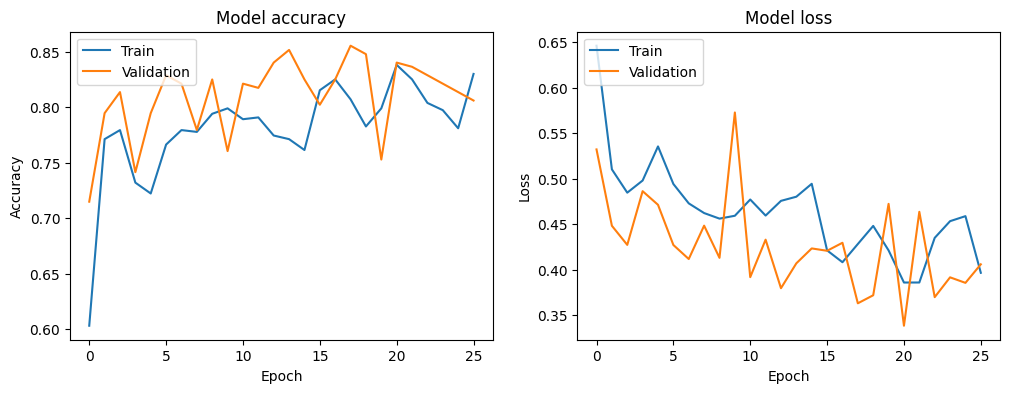

In [83]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig("training.png", bbox_inches ="tight")

plt.show()

In [84]:
# Save the model
#model.save('crop_freshness_model.h5')

## Evaluasi Hasil

In [85]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step

Confusion Matrix:
[[110  28]
 [ 14 111]]


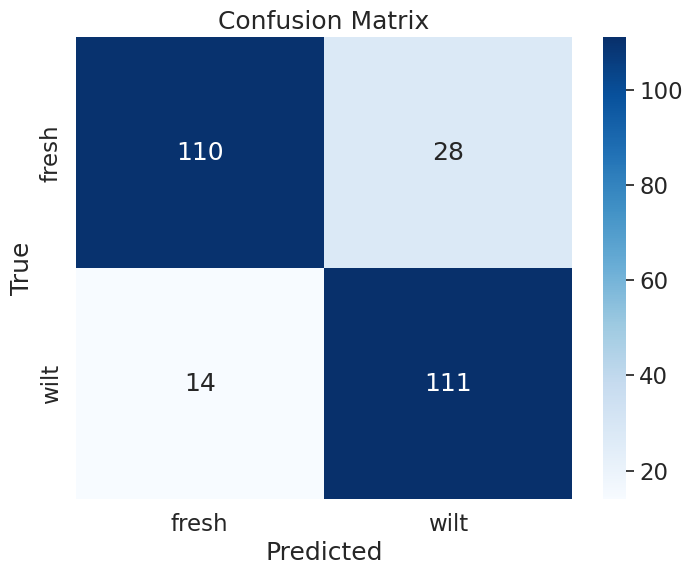


Classification Report:
              precision    recall  f1-score   support

       fresh       0.89      0.80      0.84       138
        wilt       0.80      0.89      0.84       125

    accuracy                           0.84       263
   macro avg       0.84      0.84      0.84       263
weighted avg       0.85      0.84      0.84       263



In [86]:
# Evaluate the model on the test set and get predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("Confusion Matrix.png", bbox_inches ="tight")

plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

## Visualisasi Model Deep Learning

In [88]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 10.8 MB/s eta 0:00:00


In [89]:
import visualkeras

In [90]:
from PIL import ImageFont

In [96]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
#font = ImageFont.truetype("arial.ttf", 16)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


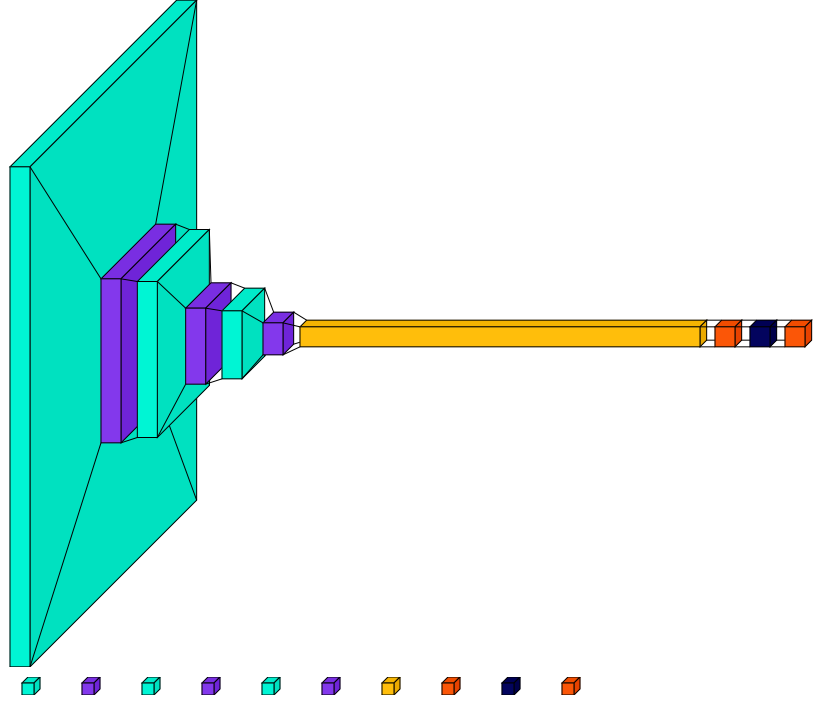

In [97]:
visualkeras.layered_view(model, legend=True,color_map=color_map, show_dimension=True, spacing=15, to_file='hidroponik.png')